In [1]:
library(cowplot)
library(ggrepel)
library(tidyverse)

theme_set(theme_cowplot())
results <- '../results/'

method_palette <- c('dmgwas' = '#4daf4a', 'heinz' = '#984ea3',
                    'hotnet2' = '#ff7f00', 'scones_gs' = '#fb6a4a',
                    'scones_gm' = '#cb181d', 'scones_gi' = '#67000d',
                    'sigmod' = '#377eb8', 'all_snps' = 'black', 'lean' = 'black', 
                    'consensus' = 'black', 'chi2' = '#000080', 'vegas' = 'red')
labs <- c('all_snps' = 'All', 'chi2' = bquote(chi^2 ~ '+ Bonferroni'), 
          'consensus' = 'Consensus', 'dmgwas' = 'dmGWAS', 'heinz' = 'heinz', 
          'hotnet2' = 'HotNet2', 'lean' = 'LEAN', 'scones_gi' = 'SConES GI', 
          'scones_gm' = 'SConES GM', 'scones_gs' = 'SConES GS', 'sigmod' = 'SigMod')

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In this notebook, I examine the results on the benchmark of the different network methods.

# HT network

First, we ran all the different methods on the so called HT network, containing only interactions from high-throughtput experiments, and hence, unbiased by well-studied genes.

## Prediction accuracy

Each method produced a subset of SNPs (or genes, which we mapped back to SNPs). We trained a Lasso classifier on these SNPs to evaluate how well those SNPs could separate cases from controls, and hence potentially be used for diagnosis.

In [2]:
pred_ht <- read_tsv(paste0(results,'benchmark/prediction.tsv'), col_types = 'ciidd')

In [3]:
summary(pred_ht$sensitivity)
summary(pred_ht$specificity)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4866  0.5254  0.5478  0.5439  0.5685  0.5991 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4779  0.5148  0.5437  0.5430  0.5674  0.6106 

`summarise()` ungrouping output (override with `.groups` argument)



method,se_sensitivity,se_specificity,sensitivity,specificity
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
all_snps,0.012548685,0.01771206,0.5503509,0.5528553
chi2,0.018096316,0.02356576,0.5597464,0.5362492
consensus,0.016071808,0.01464811,0.5384122,0.5389246
dmgwas,0.008801807,0.01430117,0.5602796,0.5590798
heinz,0.011932329,0.01997018,0.5515621,0.5562953
hotnet2,0.013991922,0.01086949,0.5483885,0.5467024
scones_gi,0.015361605,0.01110482,0.5202765,0.5192842
scones_gm,0.012556616,0.01742333,0.5278075,0.5341493
scones_gs,0.005496187,0.01652765,0.5513499,0.5539750


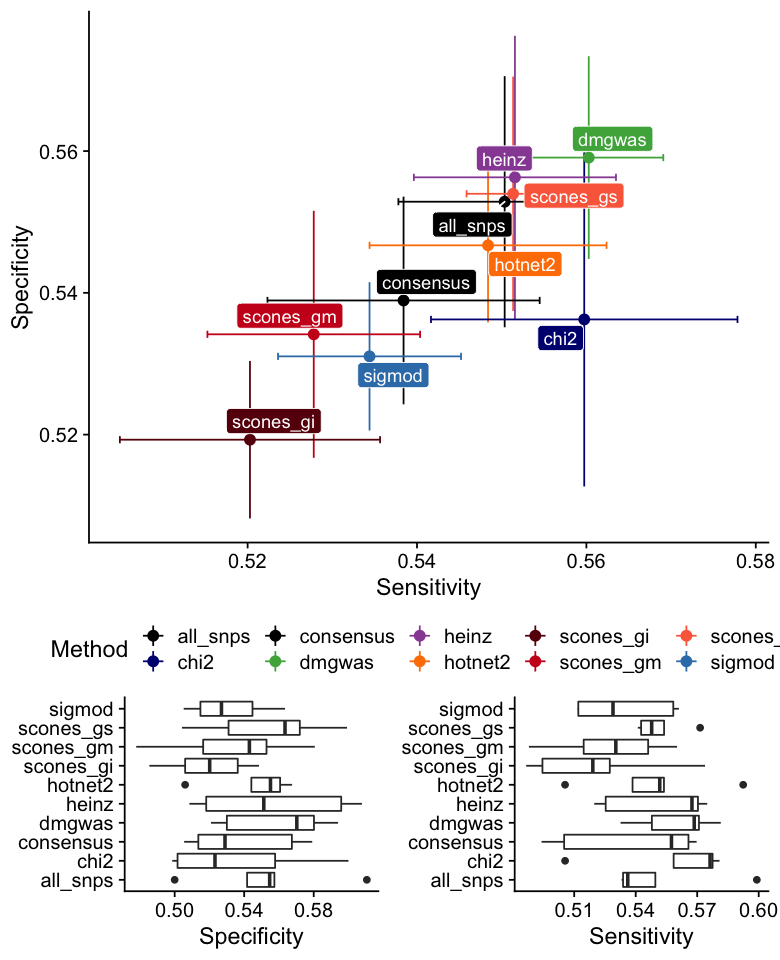

In [4]:
options(repr.plot.width=6.5, repr.plot.height=8)
specificity <- ggplot(pred_ht, aes(x = method, y = specificity)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Specificity') +
    theme(axis.title.y = element_blank())

sensitivity <- ggplot(pred_ht, aes(x = method, y = sensitivity)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Sensitivity') +
    theme(axis.title.y = element_blank())

sens_spec_df <- pred_ht %>%
    group_by(method) %>%
    summarize(se_sensitivity = sd(sensitivity) / sqrt(n()),
              se_specificity = sd(specificity) / sqrt(n()),
              sensitivity = mean(sensitivity),
              specificity = mean(specificity))
sens_spec_df

sens_spec <- ggplot(sens_spec_df, aes(x = sensitivity, y = specificity, 
           label = method, fill = method, color = method)) +
    geom_pointrange(aes(ymin = specificity - se_specificity, 
                        ymax = specificity + se_specificity)) +
    geom_errorbarh(aes(xmax = sensitivity + se_sensitivity, 
                       xmin = sensitivity - se_sensitivity)) +
    geom_label_repel(color = 'white') +
#         scale_y_continuous(limits = c(0.46, 0.62)) +
#         scale_x_continuous(limits = c(0.46, 0.62)) +
    scale_fill_manual(values = method_palette) +
    scale_color_manual(values = method_palette) +
    labs(x = 'Sensitivity', y = 'Specificity', color = 'Method') +
    theme(legend.position = 'bottom') + 
    guides(fill = "none")

plot_grid(sens_spec, plot_grid(specificity, sensitivity), nrow = 2, 
          rel_heights = c(2.5,1))

The sensitivity and the specificity from the features selected by the different methods is pretty similar to the classifier using all the SNPs in the dataset ("All" in the figure above).

In [5]:
pred_ht %>%
    mutate(which = ifelse(method == 'All', 'All', 'Network method'),
           which = ifelse(method %in% c('SConES GS', 'SConES GM', 'Bonferroni', 'Consensus'), 'Other', which)) %>%
    group_by(which) %>%
    summarize(sensitivity = mean(sensitivity),
              specificity = mean(specificity))

`summarise()` ungrouping output (override with `.groups` argument)



which,sensitivity,specificity
<chr>,<dbl>,<dbl>
Network method,0.5439407,0.5429903


## Size of the solution

`summarise()` ungrouping output (override with `.groups` argument)



method,se_selected,se_active,n_selected,n_active_set,percentage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
all_snps,0.000000,21.9818107,197083.0,96.00,0.04871044
chi2,1.779513,0.4787136,10.0,2.75,27.50000000
consensus,2694.891463,138.8857804,8249.0,585.60,7.09904231
dmgwas,471.711077,31.7184489,4038.2,316.60,7.84012679
heinz,4.200000,1.0770330,186.2,9.60,5.15574651
hotnet2,348.704373,25.5017646,7758.8,659.80,8.50389235
scones_gi,1757.346209,193.0668278,5590.0,755.00,13.50626118
scones_gm,2029.214602,138.3893059,2625.0,159.00,6.05714286
scones_gs,417.019832,12.0391030,1443.2,47.20,3.27050998


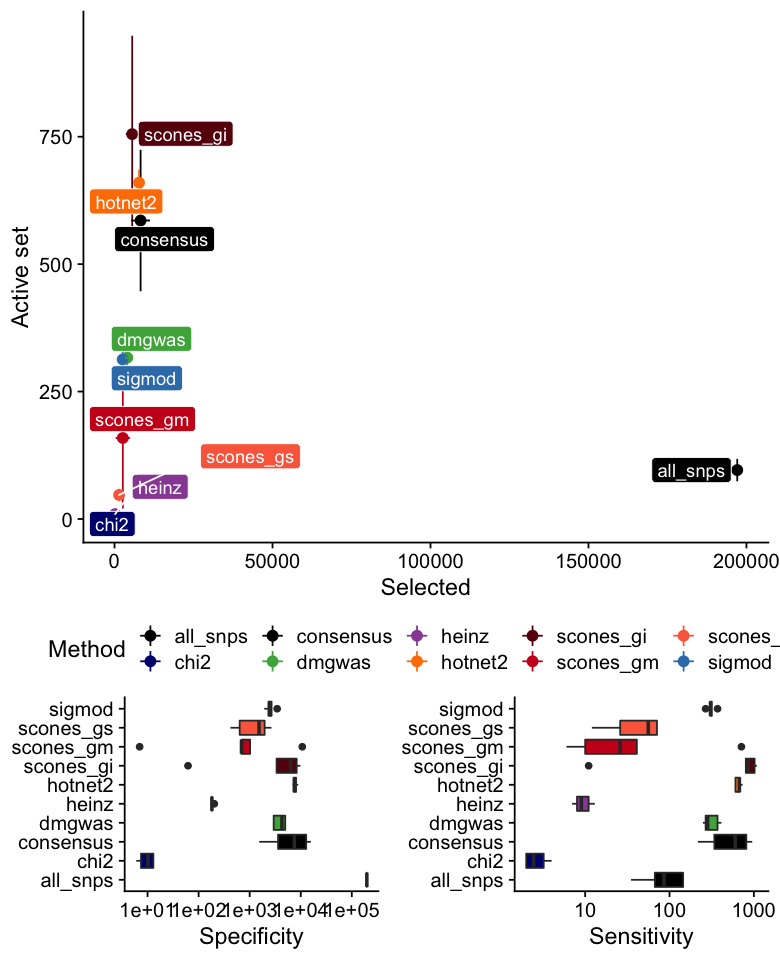

In [6]:
options(repr.plot.width=6.5, repr.plot.height=8)
selected <- ggplot(pred_ht, aes(x = method, y = n_selected, fill = method)) +
    geom_boxplot() +
    scale_y_log10() +
    coord_flip() +
    scale_fill_manual(values = method_palette) +
    labs(y = 'Specificity') +
    theme(axis.title.y = element_blank()) +
    theme(legend.position = 'none')

active <- ggplot(pred_ht, aes(x = method, y = n_active_set, fill = method)) +
    geom_boxplot() +
    scale_y_log10() +
    coord_flip() +
    scale_fill_manual(values = method_palette) +
    labs(y = 'Sensitivity') +
    theme(axis.title.y = element_blank()) +
    theme(legend.position = 'none')

sel_act_df <- pred_ht %>%
    filter(method != 'All') %>%
    group_by(method) %>%
    summarize(se_selected = sd(n_selected) / sqrt(n()),
              se_active = sd(n_active_set) / sqrt(n()),
              n_selected = mean(n_selected),
              n_active_set = mean(n_active_set),
              percentage = 100 * (n_active_set / n_selected))
sel_act_df

sel_act <- ggplot(sel_act_df, aes(x = n_selected, y = n_active_set, 
               label = method, fill = method, color = method)) +
        geom_pointrange(aes(ymin = n_active_set - se_active, 
                            ymax = n_active_set + se_active)) +
        geom_errorbarh(aes(xmax = n_selected + se_selected, 
                           xmin = n_selected - se_selected)) +
        geom_label_repel(color = 'white') +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Selected', y = 'Active set', color = 'Method') +
        theme(legend.position = 'bottom') + 
        guides(fill = "none")

plot_grid(sel_act, plot_grid(selected, active), nrow = 2, rel_heights = c(2.5,1))

## Stability

In [7]:
stab_ht <- read_tsv(paste0(results,'benchmark/stability.tsv'), col_types = 'cicd')

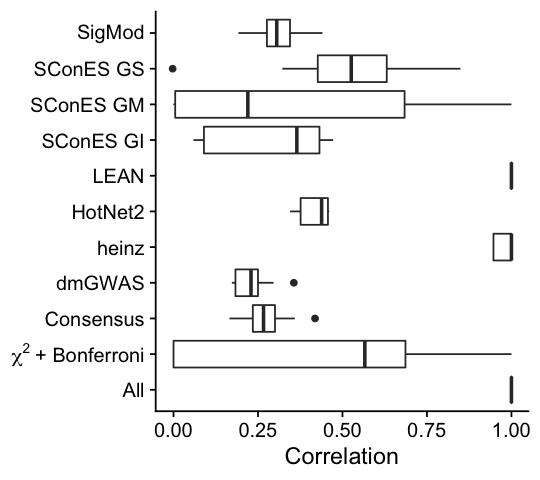

In [8]:
options(repr.plot.width=4.5, repr.plot.height=4)
ggplot(stab_ht, aes(x = method, y = pearson)) +
    geom_boxplot() +
    scale_x_discrete(labels = labs) +
    coord_flip() +
    labs(y = 'Correlation') +
    theme(axis.title.y = element_blank())

In [9]:
stab_ht %>%
    mutate(which = ifelse(method %in% c('scones_gs', 'scones_gm', 'chi2', 'consensus'), method, 'Network methods')) %>%
    group_by(which) %>%
    summarize(pearson = median(pearson))

`summarise()` ungrouping output (override with `.groups` argument)



which,pearson
<chr>,<dbl>
chi2,0.5661210
consensus,0.2663920
Network methods,0.4499258
scones_gm,0.2199438
scones_gs,0.5259718


## Computational time

In [10]:
parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else if (grepl('d', x)) {
            x <- gsub('d', '', x) %>% as.numeric
            x <- x * 3600 * 24
        } else {
            x <- NA
        }
        return(x)   
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist  
}

Warning message:
“1 parsing failure.
row  col   expected actual                             file
 89 exit an integer      - '../results/benchmark/trace.txt'
”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [128, 133].”


[1] 31533.8

`summarise()` ungrouping output (override with `.groups` argument)



method,time_s,time_star
<chr>,<dbl>,<dbl>
Bonferroni,3.86,31537.66
Consensus,2.24,31536.04
dmGWAS,36944.80,68478.60
heinz,17.46,31551.26
hotnet2,308519.80,340053.60
LEAN,372.80,31906.60
SConES GI,64500.00,64500.00
SConES GM,3115.80,3115.80
SConES GS,457.00,457.00


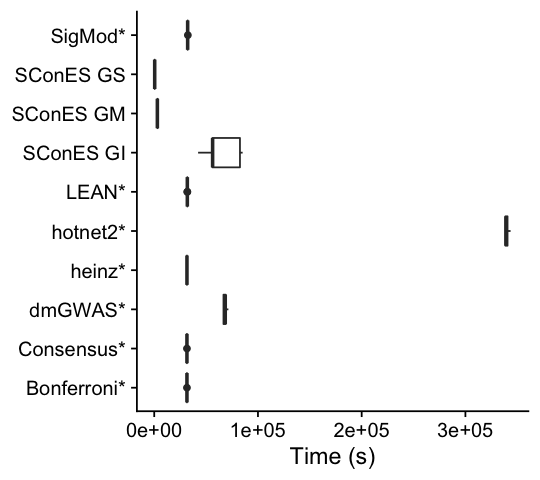

In [11]:
time <- read_tsv(paste0(results,'benchmark/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses')) %>%
    mutate(method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'Bonferroni', method),
           method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method)) %>%
    mutate(time_s = parse_deltatime(realtime))

vegas <- mean(time$time_s[time$method == 'vegas'])

options(repr.plot.width=4.5, repr.plot.height=4)
time_star <- time %>%
    filter(method != 'vegas') %>%
    mutate(time_star = ifelse(grepl('SConES', method), time_s, time_s + vegas),
           method_star = ifelse(grepl('SConES', method), method, paste0(method,'*')))

vegas
time_star %>%
    group_by(method) %>%
    summarize(time_s = mean(time_s),
              time_star = mean(time_star))

ggplot(time_star, aes(x = method_star, y = time_star, fill = method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_palette) +
    labs(y = 'Time (s)') +
    theme(legend.position = 'none',
          axis.title.y = element_blank()) +
    coord_flip()

# HT+LC network

In [12]:
pred_lc <- read_tsv(paste0(results,'lc_ht_network/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'Bonferroni', method),
           method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method))

`summarise()` ungrouping output (override with `.groups` argument)



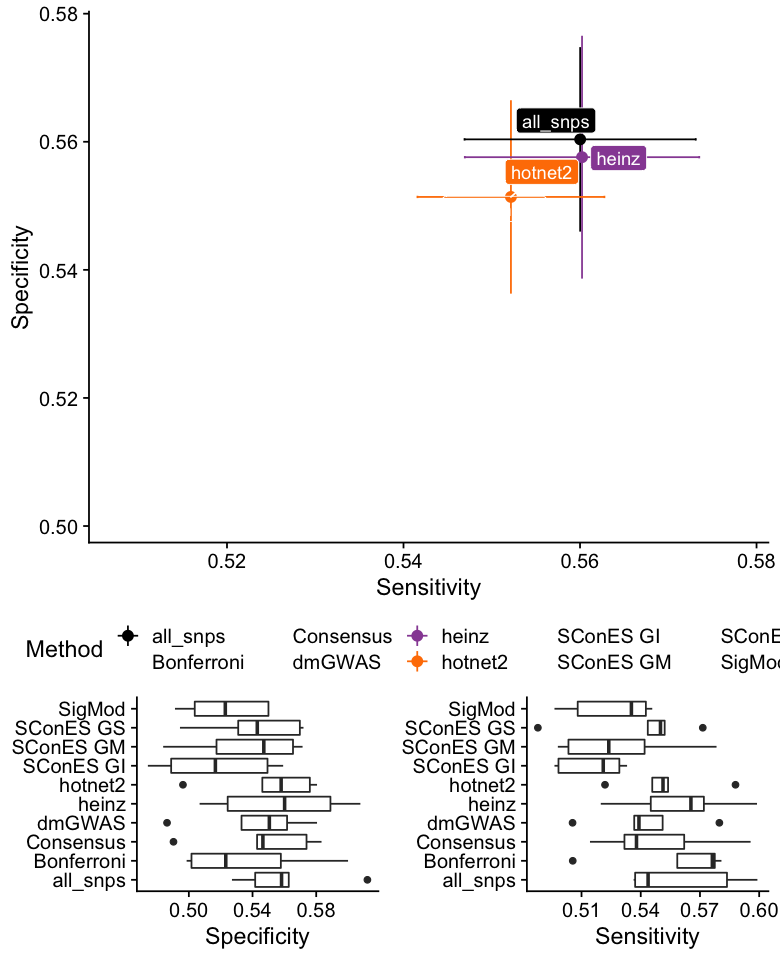

In [13]:
options(repr.plot.width=6.5, repr.plot.height=8)
specificity <- ggplot(pred_lc, aes(x = method, y = specificity)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Specificity') +
    theme(axis.title.y = element_blank())

sensitivity <- ggplot(pred_lc, aes(x = method, y = sensitivity)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Sensitivity') +
    theme(axis.title.y = element_blank())

sens_spec <- pred_lc %>%
    group_by(method) %>%
    summarize(se_sensitivity = sd(sensitivity) / sqrt(n()),
              se_specificity = sd(specificity) / sqrt(n()),
              sensitivity = mean(sensitivity),
              specificity = mean(specificity)) %>%
    ggplot(aes(x = sensitivity, y = specificity, 
               label = method, fill = method, color = method)) +
        geom_pointrange(aes(ymin = specificity - se_specificity, 
                            ymax = specificity + se_specificity)) +
        geom_errorbarh(aes(xmax = sensitivity + se_sensitivity, 
                           xmin = sensitivity - se_sensitivity)) +
        geom_label_repel(color = 'white') +
#         scale_y_continuous(limits = c(0.46, 0.62)) +
#         scale_x_continuous(limits = c(0.46, 0.62)) +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Sensitivity', y = 'Specificity', color = 'Method') +
        theme(legend.position = 'bottom') + 
        guides(fill = "none")

plot_grid(sens_spec, plot_grid(specificity, sensitivity), nrow = 2, 
          rel_heights = c(2.5,1))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



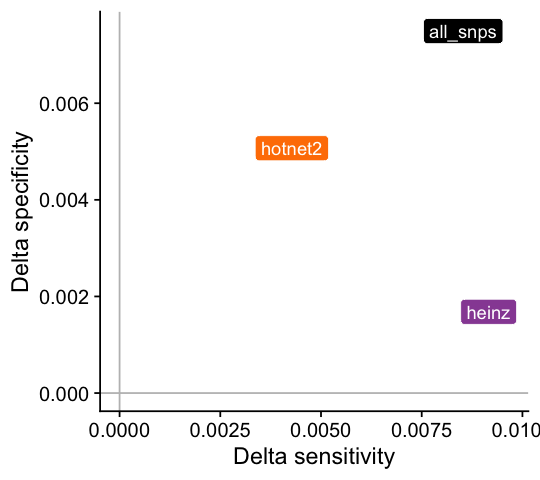

In [14]:
options(repr.plot.width=4.5, repr.plot.height=4)
inner_join(pred_lc %>%
           group_by(method) %>%
           summarize(sensitivity = mean(sensitivity),
                     specificity = mean(specificity)),
           pred_ht %>%
           group_by(method) %>%
           summarize(sensitivity = mean(sensitivity),
                     specificity = mean(specificity)),
           by = 'method', suffix = c('_ht','_lc')) %>%
    group_by(method) %>%
    summarize(delta_sensitivity = sensitivity_ht - sensitivity_lc,
              delta_specificity = specificity_ht - specificity_lc) %>%
    ggplot(aes(x = delta_sensitivity, y = delta_specificity, 
               label = method, fill = method)) +
        geom_hline(yintercept = 0, color = 'gray') +
        geom_vline(xintercept = 0, color = 'gray') +
        geom_label_repel(color = 'white') +
        scale_fill_manual(values = method_palette) +
        labs(x = 'Delta sensitivity', y = 'Delta specificity') +
        theme(legend.position = 'none')

`summarise()` ungrouping output (override with `.groups` argument)



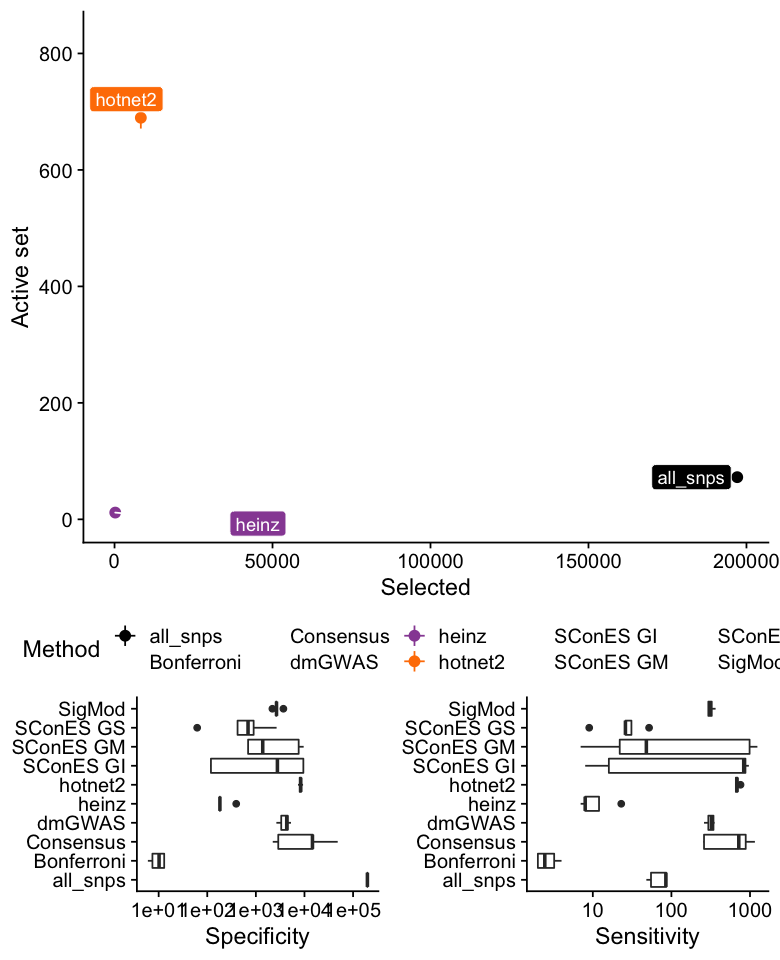

In [15]:
options(repr.plot.width=6.5, repr.plot.height=8)
selected <- ggplot(pred_lc, aes(x = method, y = n_selected)) +
    geom_boxplot() +
    scale_y_log10() +
    coord_flip() +
    labs(y = 'Specificity') +
    theme(axis.title.y = element_blank())

active <- ggplot(pred_lc, aes(x = method, y = n_active_set)) +
    geom_boxplot() +
    scale_y_log10() +
    coord_flip() +
    labs(y = 'Sensitivity') +
    theme(axis.title.y = element_blank())

sel_act <- pred_lc %>%
    group_by(method) %>%
    summarize(se_selected = sd(n_selected) / sqrt(n()),
              se_active = sd(n_active_set) / sqrt(n()),
              n_selected = mean(n_selected),
              n_active_set = mean(n_active_set)) %>%
    ggplot(aes(x = n_selected, y = n_active_set, 
               label = method, fill = method, color = method)) +
        geom_pointrange(aes(ymin = n_active_set - se_active, 
                            ymax = n_active_set + se_active)) +
        geom_errorbarh(aes(xmax = n_selected + se_selected, 
                           xmin = n_selected - se_selected)) +
        geom_label_repel(color = 'white') +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Selected', y = 'Active set', color = 'Method') +
        theme(legend.position = 'bottom') + 
        guides(fill = "none")

plot_grid(sel_act, plot_grid(selected, active), nrow = 2, rel_heights = c(2.5,1))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



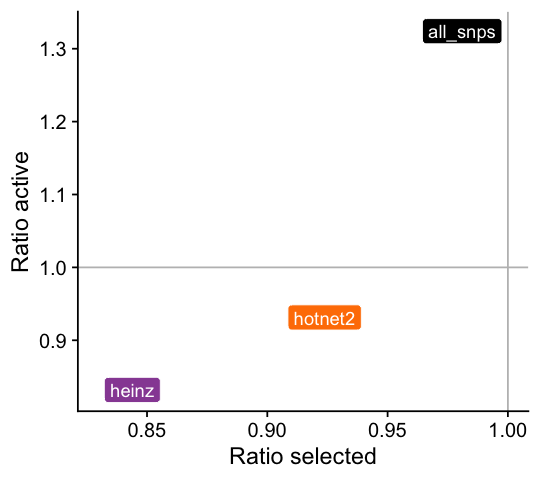

In [16]:
options(repr.plot.width=4.5, repr.plot.height=4)
inner_join(pred_lc %>%
           group_by(method) %>%
           summarize(n_selected = mean(n_selected),
                     n_active = mean(n_active_set)),
           pred_ht %>%
           group_by(method) %>%
           summarize(n_selected = mean(n_selected),
                     n_active = mean(n_active_set)),
           by = 'method', suffix = c('_ht','_lc')) %>%
    group_by(method) %>%
    summarize(delta_selected = n_selected_lc/n_selected_ht,
              delta_active = n_active_lc/n_active_ht) %>%
    ggplot(aes(x = delta_selected, y = delta_active, 
               label = method, fill = method)) +
        geom_hline(yintercept = 1, color = 'gray') +
        geom_vline(xintercept = 1, color = 'gray') +
        geom_label_repel(color = 'white') +
        scale_fill_manual(values = method_palette) +
        labs(x = 'Ratio selected', y = 'Ratio active') +
        theme(legend.position = 'none')

# Paramater exploration

In [17]:
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`)

bcac <- read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>%
    # remove genes not in the PPI
    filter(Gene %in% ppi$`Official Symbol Interactor A` | Gene %in% ppi$`Official Symbol Interactor B`)
bcac_snps <- read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), col_types = 'icdcddcddd') %>%
    mutate(padj = p.adjust(P, method = 'bonferroni'))

# from DisGeNET
## genes
all_genes <- c(ppi$`Official Symbol Interactor A`, ppi$`Official Symbol Interactor B`) %>% unique
disgenet <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene
# P_genes <- intersect(all_genes, disgenet)
# N_genes <- setdiff(all_genes, disgenet)

P_genes <- intersect(all_genes, disgenet) %>% union(filter(bcac, `Top-0.1-pvalue` < 0.05 / n())$Gene)
N_genes <- setdiff(all_genes, P_genes)


## snps
all_snps <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                      col_types = 'icdccccddd')$SNP
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc') %>%
    filter(snp %in% all_snps)

P_snps <- snp2gene$snp[snp2gene$gene %in% P_genes]
N_snps <- snp2gene$snp[! snp2gene$gene %in% P_genes]

P_genes <- filter(bcac, `Top-0.1-pvalue` < 0.05 / n())$Gene
N_genes <- filter(bcac, `Top-0.1-pvalue` >= 0.05 / n())$Gene

P_snps <- filter(bcac_snps, padj  < 0.05 / n())$SNP
N_snps <- filter(bcac_snps, padj >= 0.05 / n())$SNP

In [22]:
read_vegas <- function() {
    chi2 <- read_tsv(paste0(results, 'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>%
        filter(Gene %in% bcac$Gene)
    thresholds <- c(1e-6, 1e-4, 1e-2, seq(0, 1, 0.05))
    
    lapply(thresholds, function(cutoff) {
        filter(chi2, `Top-0.1-pvalue` < cutoff) %>%
            mutate(method = 'vegas',
                   tp = Gene %in% P_genes,
                   params = as.character(cutoff)) %>%
        select(Gene, method, params, tp)
    }) %>%
    bind_rows
}

read_dmgwas <- function() {
    
    lapply(list.files(paste0(results,'params/dmgwas'), full.names = T, pattern = 'dmgwas_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(params = gsub('.*dmgwas_', '', f)  %>% gsub('.txt', '', .),
                   d = gsub('d_', '', params) %>% gsub('_r_.*', '', .) %>% as.numeric,
                   r = gsub('d_[1-3]_r_', '', params) %>% as.numeric, 
                   method = 'dmgwas',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
    
}

read_heinz <- function() {
    lapply(list.files(paste0(results,'params/heinz'), full.names = T, pattern = 'heinz_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(params = gsub('.*heinz_', '', f)  %>% gsub('.txt', '', .),
                   method = 'heinz',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
}

read_hotnet <- function() {
    lapply(list.files(paste0(results,'params/hotnet2'), full.names = T, pattern = 'hotnet2_*'), function(f) {
        read_tsv(f, col_types = 'ci') %>%
            select(gene) %>%
            mutate(params = gsub('.*hotnet2_', '', f)  %>% gsub('.tsv', '', .),
                   method = 'hotnet2',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
}

read_lean <- function() {
    lean <- read_tsv(paste0(results, 'lean/scored_genes.lean.txt'), col_types = 'cddiidddd')

    lapply(seq(0, 1, 0.025), function(cutoff) {
        filter(lean, PLEAN < cutoff) %>%
            mutate(method = 'lean',
                   tp = Gene %in% P_genes,
                   params = as.character(cutoff)) %>%
        select(Gene, method, params, tp)
    }) %>%
        bind_rows
}

read_sigmod <- function() {
    
    lapply(list.files(paste0(results,'params/sigmod'), full.names = T, pattern = 'sigmod_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(params = gsub('.*sigmod_', '', f)  %>% gsub('.txt', '', .),
                   method = 'sigmod',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
    
}

read_scones <- function() {
    lapply(list.files(paste0(results,'params/scones'), full.names = T, pattern = 'cones_*'), function(f) {
        read_tsv(f, col_types = 'ciidccdli') %>%
            filter(selected) %>%
            select(snp) %>%
            mutate(params = gsub('.*cones_', '', f)  %>% gsub('.tsv', '', .),
                   method = 'scones_gi',
                   tp = snp %in% P_snps)
        }) %>%
        bind_rows %>%
        group_by(method, params) %>%
        summarize(tpr = sum(tp) / length(P_snps),
                  fpr = (n() - sum(tp)) / length(N_snps),
                  n   = n(),
                  type = 'snp',
                  eta = gsub('eta_', '', params) %>% gsub('_lambda_.*', '', .) %>% as.numeric,
                  lambda = gsub('eta_.*_lambda_', '', params) %>% as.numeric)
}
           
read_chi2 <- function() {
    chi2 <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), col_types = 'icdccccddd')
    thresholds <- c(1e-6, 1e-4, 1e-2, seq(0, 1, 0.05))
    
    lapply(thresholds, function(cutoff) {
        filter(chi2, P < cutoff) %>%
            rename(snp = SNP) %>%
            mutate(method = 'chi2',
                   tp = snp %in% P_snps,
                   params = as.character(cutoff)) %>%
        select(snp, method, params, tp)
    }) %>%
    bind_rows %>%
    group_by(method, params) %>%
    summarize(tpr = sum(tp) / length(P_snps),
              fpr = (n() - sum(tp)) / length(N_snps),
              n   = n(),
              type = 'snp')
}

dmgwas_pars <- read_dmgwas()
scones_pars <- read_scones()

stats <- bind_rows(read_vegas(),
                   dmgwas_pars %>% select(-d, -r),
                   read_heinz(),
                   read_hotnet(),
                   read_lean(),
                   read_sigmod()
                  ) %>%
    group_by(method, params) %>%
    summarize(fpr = (n() - sum(tp)) / length(N_genes),
              tpr = sum(tp) / length(P_genes),
              n   = n(),
              type = 'gene') %>%
    bind_rows(scones_pars %>% select(-eta, -lambda),
              read_chi2()) %>%
    ungroup %>%
    add_row(method = 'vegas', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'dmgwas', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'heinz', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'hotnet2', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'lean', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'sigmod', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'chi2', params = NA, tpr = 1, fpr = 1, type = 'snp') %>%
    add_row(method = 'scones_gi', params = NA, tpr = 1, fpr = 1, type = 'snp')

`summarise()` regrouping output by 'method', 'params' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)



Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


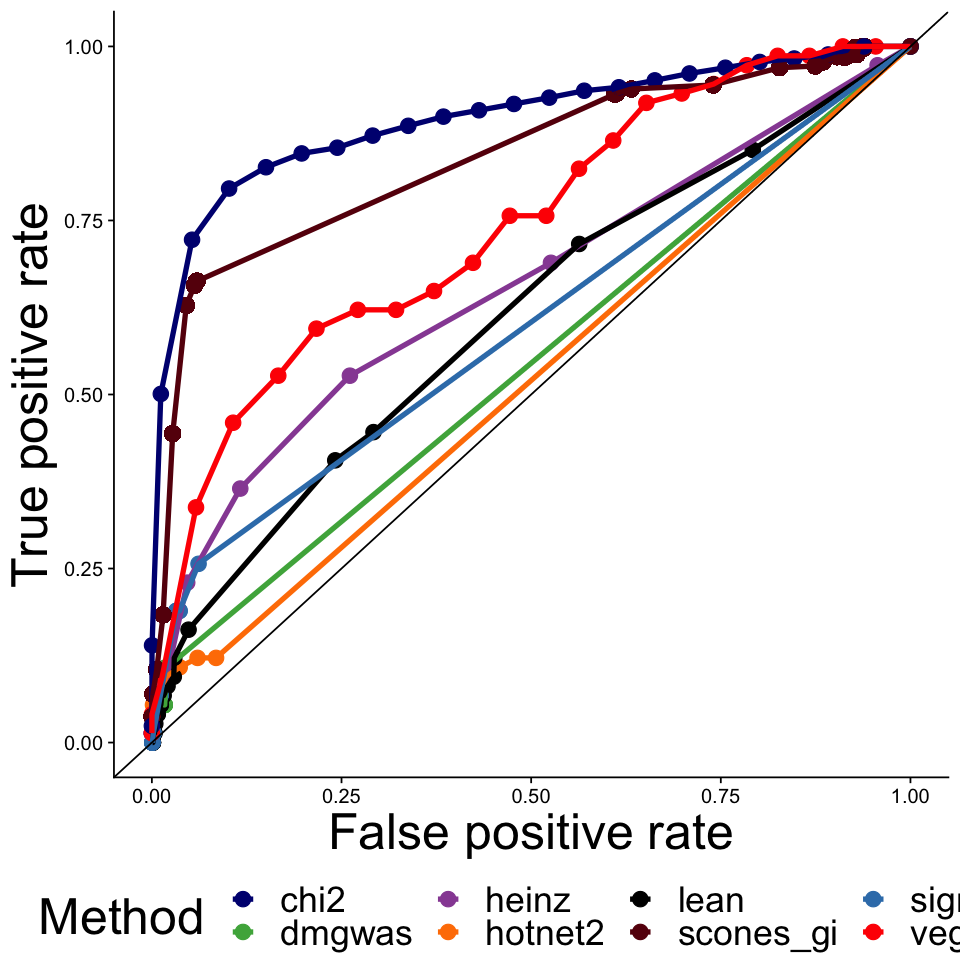

In [19]:
options(repr.plot.width=8, repr.plot.height=8)
stats %>%
    ggplot(aes(fpr, tpr, color = method)) +
        geom_point(size = 4) +
        geom_line(size = 1.5) +
        geom_abline(slope = 1) +
        labs(x = 'False positive rate', y = 'True positive rate', color = 'Method') +
        scale_x_continuous(lim = c(0, 1)) +
        scale_y_continuous(lim = c(0, 1)) +
        scale_color_manual(values = method_palette) +
        theme(legend.position = 'bottom',
              text = element_text(size = 25),
              title = element_text(size = 30))

Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”


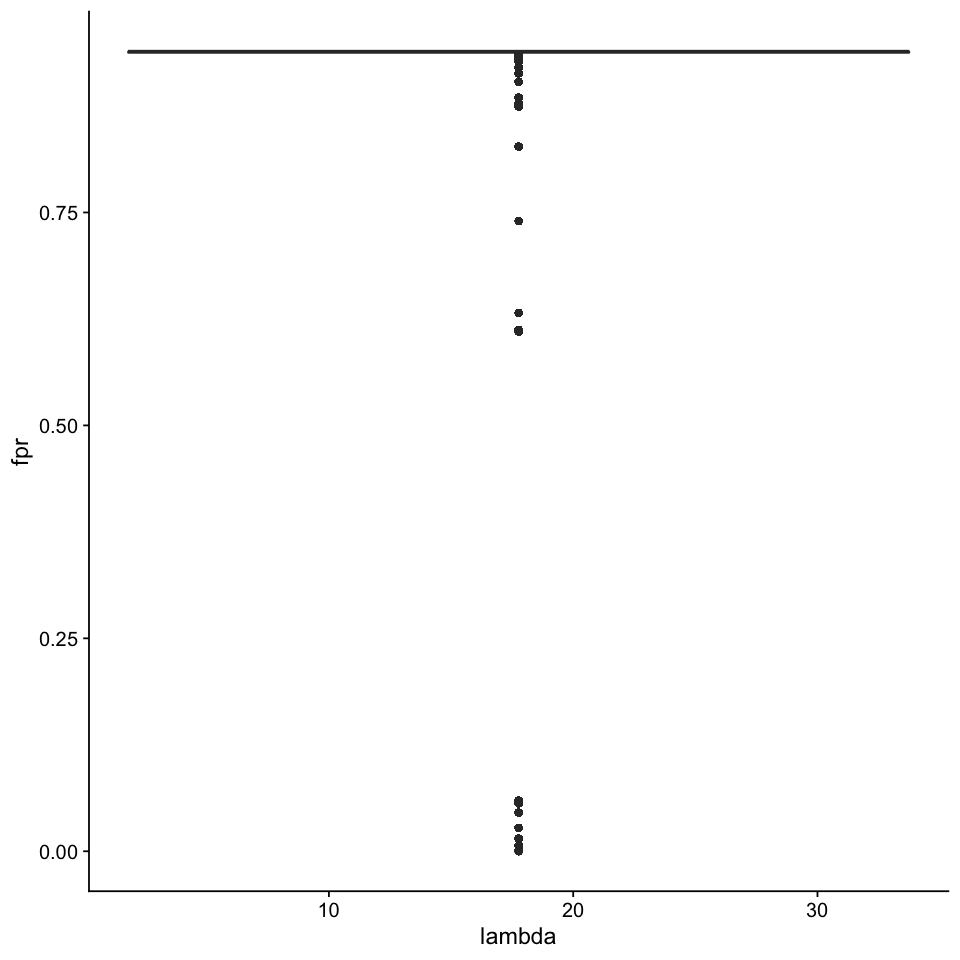

In [26]:
scones_pars %>%
    ggplot(aes(x = lambda, y = fpr)) +
        geom_boxplot()

# TODO

- Use disgenet instead of BCAC
- Check other properties that could be explored: centrality, size, association, etc.